<a href="https://colab.research.google.com/github/limjunghyeon/ESAA_py/blob/main/ESAA_3%EC%A1%B0_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **[ 방학 프로젝트 ]**
### **8기 3조 - 서혜현, 곽지수, 임정현, 서유진, 이인서**

- 관련 사이트: https://dacon.io/competitions/official/236094/overview/description
- DACON의 baseline 코드를 참고하며 프로젝트를 진행하였습니다.

### **1. 배경**

실생활에서 우리는 꽤 자주 답을 알 수 없는 문제에 직면하곤 합니다. 그럴 때마다 그간의 경험 속에서 패턴과 구조를 찾고, 이를 사용해서 주어진 과제를 해결해 나가죠.


이와 마찬가지로 준지도학습은 특정한 목적이나 레이블이 거의 없는 상태에서 컴퓨터가 데이터의 패턴을 학습하여 레이블을 부여하는 머신러닝 기술입니다. 준지도학습은 데이터의 레이블링에 드는 비용을 절약할 수 있어 다양한 사업 분야에서 활발히 쓰이고 있습니다.

이번 월간 데이콘 항공편 지연 예측 AI 경진대회에서는 바로 이러한 준지도학습을 활용한 AI 모델 개발을 목표로 합니다.


### **2. 주제**

일부 레이블만 주어진 학습 데이터셋을 이용한 항공편 지연 여부 예측

### **3. 설명**

레이블이 없는 데이터와 함께 항공편 지연 여부를 예측하는 AI 모델을 만들어주세요!

### **4. 데이터 및 사전 학습 모델 허용 범위**

대회 제공 데이터 이외의 외부 데이터 사용 금지

사용에 법적 제약이 없고 논문으로 공개된 베이스의 사전 학습된 모델(Pretrained Model Weight) 사용 가능. 단, Test Dataset이 포함된 사전 학습 모델 사용 불가

## **5. 데이터 설명**

* ID : 샘플 고유 id
* Month: 해당 항공편의 출발 월
* Day_of_Month: Month에 해당하는 월의 날짜
* Estimated_Departure_Time: 전산 시스템을 바탕으로 측정된 비행기의 출발 시간 (현지 시각, HH:MM 형식)
* Estimated_Arrival_Time: 전산 시스템을 바탕으로 측정된 비행기의 도착 시간 (현지 시각, HH:MM 형식)
* Cancelled: 해당 항공편의 취소 여부 (0: 취소되지 않음, 1: 취소됨)
* Diverted: 해당 항공편의 경유 여부 (0: 취소되지 않음, 1: 취소됨)
* Origin_Airport: 해당 항공편 출발 공항의 고유 코드 (IATA 공항 코드)
* Origin_Airport_ID: 해당 항공편 출발 공항의 고유 ID (US DOT ID)
* Origin_State: 해당 항공편 출발 공항이 위치한 주의 이름
* Destination_Airport: 해당 항공편 도착 공항의 고유 코드 (IATA 공항 코드)
* Destination_Airport_ID: 해당 항공편 도착 공항의 고유 ID (US DOT ID)
* Destination_State: 해당 항공편 도착 공항이 위치한 주의 이름
* Distance: 출발 공항과 도착 공항 사이의 거리 (mile 단위)
* Airline: 해당 항공편을 운항하는 항공사
* Carrier_Code(IATA): 해당 항공편을 운항하는 항공사의 고유 코드 (IATA 공항 코드, 단 다른 항공사가 같은 코드를 보유할 수도 있음)
* Carrier_ID(DOT): 해당 항공편을 운항하는 항공사의 고유 ID (US DOT ID)
* Tail_Number: 해당 항공편을 운항하는 항공기의 고유 등록번호
* Delay: 항공편 지연 여부 (Not_Delayed, Delayed)
예측해야 하는 타깃

#01 필요 모듈 불러오기

In [ ]:
# 나눔 폰트 설치 / 한글 깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (6,425 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123105 files and di

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic') #matplotlib 한글 깨짐 방지
import re
import gc
import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
random.seed(10)
np.random.seed(10)

#02 데이터 불러오기

참고 : https://leechanwoo-kor.github.io/python/parquet/

데이터를 쉽게 접근할 수 있도록 csv로 저장해서 사용한다. 하지만 csv는 메타데이터를 저장할 수 없어 칼럼 별로 dtype을 다시 지정해줘야 하는 일이 생기며, 읽고 쓸 때 시간이 많이 걸린다는 단점이 있다. 이를 보완하기 위해 parquet이라는 데이터 포맷을 사용한다.

* parquet은 데이터 처리 프레임워크, 데이터 모델 또는 프로그래밍 언어에 관계없이 Hadoop 생태계의 모든 프로젝트에서 사용할 수 있는 칼럼형 스토리지 형식이다.

* parquet을 사용하면 파일의 압축과 쓰기, 읽기에 탁월하다는 장점이 있으며 csv에 비해 용량이 매우 작다.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# csv를 parquet으로 변형해주는 함수 작성
# => 총 3개의 csv 파일을 변환해줄거니까 함수로 만든다
def csv_to_parquet(csv, save):
    df = pd.read_csv(csv)
    df.to_parquet(f'./{save}.parquet')
    del df
    gc.collect()
    print(save, 'Done.')

In [ ]:
csv_to_parquet('train.csv', 'train')
csv_to_parquet('test.csv', 'test')

train Done.
test Done.


In [ ]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')
sample_submission = pd.read_csv(sample_submission.csv', index_col = 0)

# 03 데이터 분석

### 1) 데이터 확인

In [ ]:
# 데이터 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  891016 non-null   float64
 4   Estimated_Arrival_Time    890952 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              893495 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         893477 non-null   object 
 13  Distance                  10

In [ ]:
# 데이터의 기술 통계량 확인
train.describe()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
count,1000000.000000,1000000.000000,890981.000000,890960.000000,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.000000,891003.000000
mean,6.945156,15.764842,1341.153019,1493.295934,0.0,0.0,12696.278484,12701.813986,784.078499,19997.388093
std,3.462506,8.763515,489.814011,520.803494,0.0,0.0,1514.938441,1515.213044,590.790469,404.268639
min,1.000000,1.000000,1.000000,1.000000,0.0,0.0,10135.000000,10135.000000,16.000000,19393.000000
25%,4.000000,8.000000,925.000000,1105.000000,0.0,0.0,11292.000000,11292.000000,350.000000,19790.000000
50%,7.000000,16.000000,1332.000000,1524.000000,0.0,0.0,12889.000000,12889.000000,623.000000,19977.000000
75%,10.000000,23.000000,1742.000000,1924.000000,0.0,0.0,14057.000000,14057.000000,1020.000000,20378.000000
max,12.000000,31.000000,2359.000000,2400.000000,0.0,0.0,16869.000000,16869.000000,5095.000000,21171.000000


In [ ]:
train.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,None
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,None


In [ ]:
test.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number
0,TEST_000000,12,16,1156.0,NaN,0,0,IAH,12266,Texas,SAT,14683,Texas,191.0,United Air Lines Inc.,UA,NaN,N79402
1,TEST_000001,9,12,1500.0,1715.0,0,0,EWR,11618,New Jersey,ATL,10397,None,746.0,Delta Air Lines Inc.,DL,19790.0,N3765
2,TEST_000002,3,6,1600.0,1915.0,0,0,ORD,13930,Illinois,LGA,12953,New York,733.0,United Air Lines Inc.,UA,19977.0,N413UA
3,TEST_000003,5,18,1920.0,2045.0,0,0,OAK,13796,California,LAX,12892,California,337.0,Southwest Airlines Co.,WN,19393.0,N905WN
4,TEST_000004,7,7,1915.0,2152.0,0,0,FLL,11697,Florida,LAX,12892,California,2343.0,JetBlue Airways,B6,20409.0,N945JT


In [ ]:
# 데이터 형태 확인
print(train.shape)
print(test.shape)

(1000000, 19)
(1000000, 18)


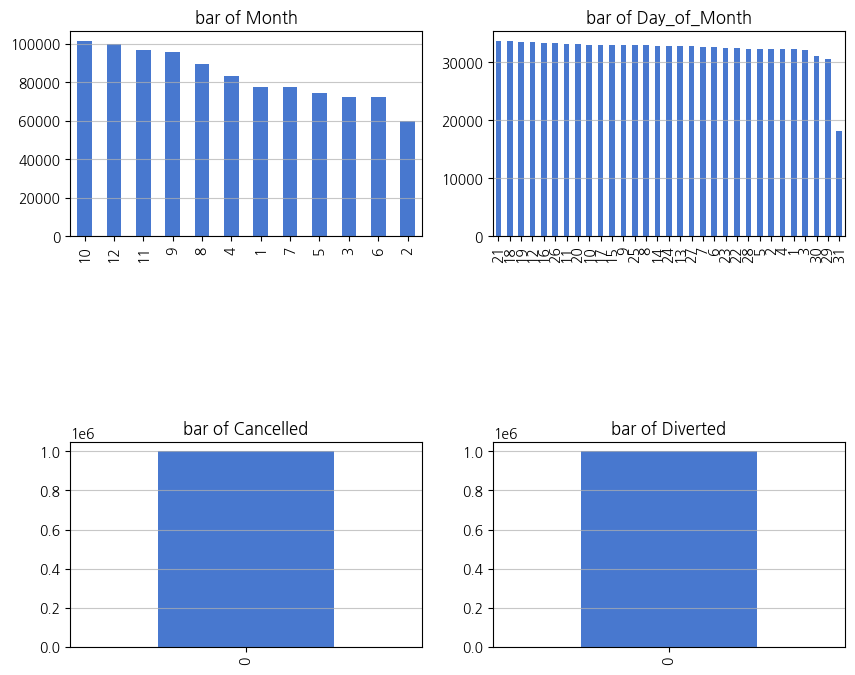

In [ ]:
plt.figure(figsize = (10, 8))
plt.subplots_adjust(hspace = 1)

plt.subplot(221)
train['Month'].value_counts(sort = True).plot.bar(rot = 90)
plt.title('bar of Month')
plt.grid(axis = 'y', alpha = 0.7)

plt.subplot(222)
train['Day_of_Month'].value_counts(sort = True).plot.bar(rot = 90)
plt.title('bar of Day_of_Month')
plt.grid(axis = 'y', alpha = 0.7)

plt.subplot(223)
train['Cancelled'].value_counts(sort = True).plot.bar(rot = 90)
plt.title('bar of Cancelled')
plt.grid(axis = 'y', alpha = 0.7)

plt.subplot(224)
train['Diverted'].value_counts(sort = True).plot.bar(rot = 90)
plt.title('bar of Diverted')
plt.grid(axis = 'y', alpha = 0.7)

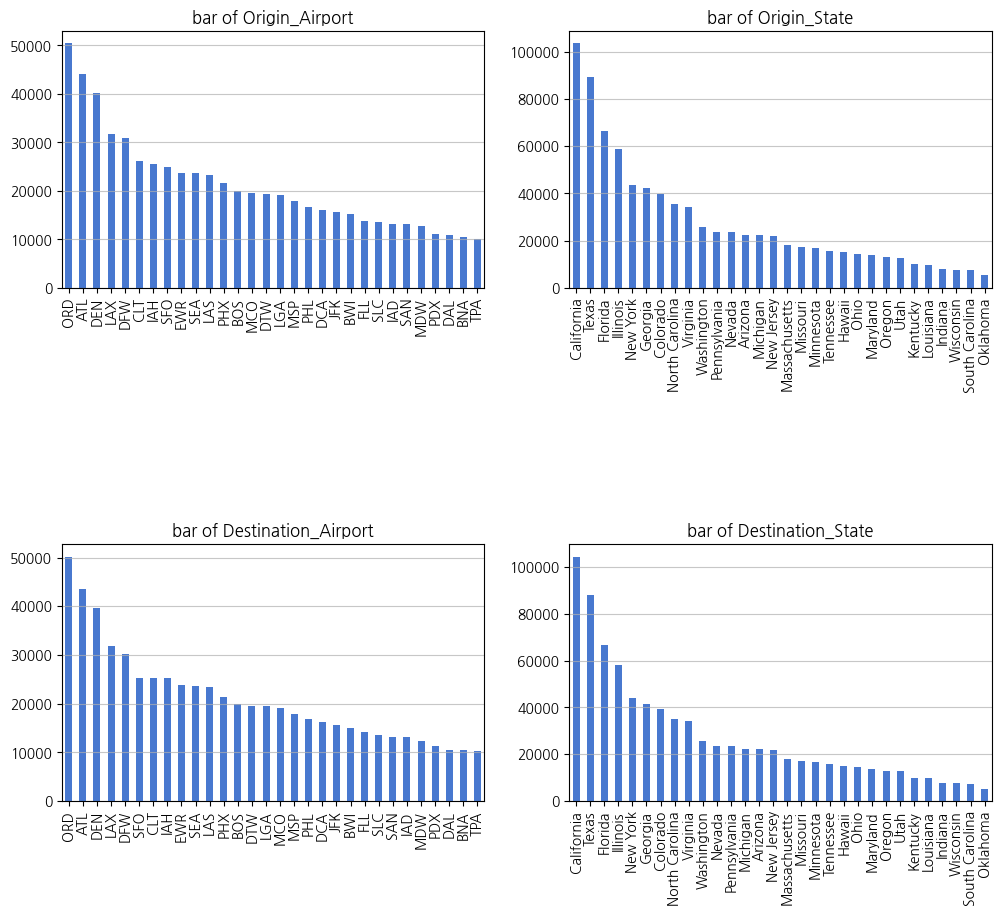

In [ ]:
plt.figure(figsize = (12, 10))
plt.subplots_adjust(hspace = 1)

plt.subplot(221)
train['Origin_Airport'].value_counts(sort = True)[:30].plot.bar(rot = 90)
plt.title('bar of Origin_Airport')
plt.grid(axis = 'y', alpha = 0.7)

plt.subplot(222)
train['Origin_State'].value_counts(sort = True)[:30].plot.bar(rot = 90)
plt.title('bar of Origin_State')
plt.grid(axis = 'y', alpha = 0.7)

plt.subplot(223)
train['Destination_Airport'].value_counts(sort = True)[:30].plot.bar(rot = 90)
plt.title('bar of Destination_Airport')
plt.grid(axis = 'y', alpha = 0.7)

plt.subplot(224)
train['Destination_State'].value_counts(sort = True)[:30].plot.bar(rot = 90)
plt.title('bar of Destination_State')
plt.grid(axis = 'y', alpha = 0.7)

<Axes: xlabel='Distance', ylabel='Density'>

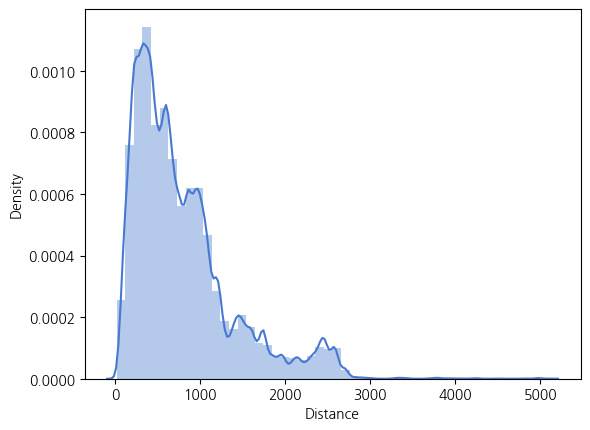

In [ ]:
sns.distplot(train['Distance'])

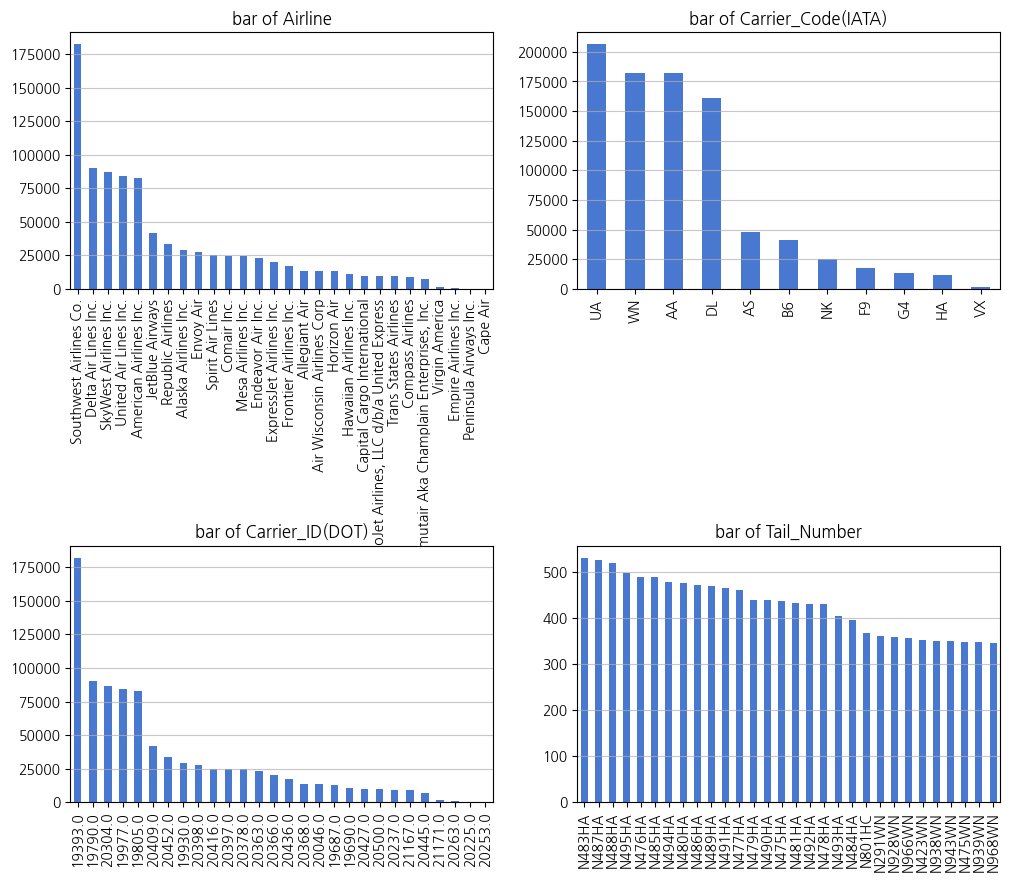

In [ ]:
plt.figure(figsize = (12, 10))
plt.subplots_adjust(hspace = 1)

plt.subplot(221)
train['Airline'].value_counts(sort = True)[:30].plot.bar(rot = 90)
plt.title('bar of Airline')
plt.grid(axis = 'y', alpha = 0.7)

plt.subplot(222)
train['Carrier_Code(IATA)'].value_counts(sort = True)[:30].plot.bar(rot = 90)
plt.title('bar of Carrier_Code(IATA)')
plt.grid(axis = 'y', alpha = 0.7)

plt.subplot(223)
train['Carrier_ID(DOT)'].value_counts(sort = True).plot.bar(rot = 90)
plt.title('bar of Carrier_ID(DOT)')
plt.grid(axis = 'y', alpha = 0.7)

plt.subplot(224)
train['Tail_Number'].value_counts(sort = True)[:30].plot.bar(rot = 90)
plt.title('bar of Tail_Number')
plt.grid(axis = 'y', alpha = 0.7)

In [ ]:
# 데이터의 상관계수 확인
pd.reset_option('display.float_format')

In [ ]:
train.corr()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
Month,1.000000,0.010119,-0.004424,-0.005983,NaN,NaN,-0.009490,-0.008929,-0.013824,0.024550
Day_of_Month,0.010119,1.000000,-0.001210,-0.001897,NaN,NaN,-0.001064,0.000521,0.002719,-0.001519
Estimated_Departure_Time,-0.004424,-0.001210,1.000000,0.683152,NaN,NaN,-0.025891,0.023767,-0.010714,-0.009664
Estimated_Arrival_Time,-0.005983,-0.001897,0.683152,1.000000,NaN,NaN,-0.008247,0.015027,0.013754,-0.002654
Cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Diverted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Origin_Airport_ID,-0.009490,-0.001064,-0.025891,-0.008247,NaN,NaN,1.000000,0.020514,0.062215,-0.029483
Destination_Airport_ID,-0.008929,0.000521,0.023767,0.015027,NaN,NaN,0.020514,1.000000,0.064447,-0.031580
Distance,-0.013824,0.002719,-0.010714,0.013754,NaN,NaN,0.062215,0.064447,1.000000,-0.112459
Carrier_ID(DOT),0.024550,-0.001519,-0.009664,-0.002654,NaN,NaN,-0.029483,-0.031580,-0.112459,1.000000


In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(data = train.corr(), annot=True)

### 2) 데이터 전처리

* 결측치 여부 확인

In [ ]:
train.isna().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                109015
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           109079
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64

<Axes: >

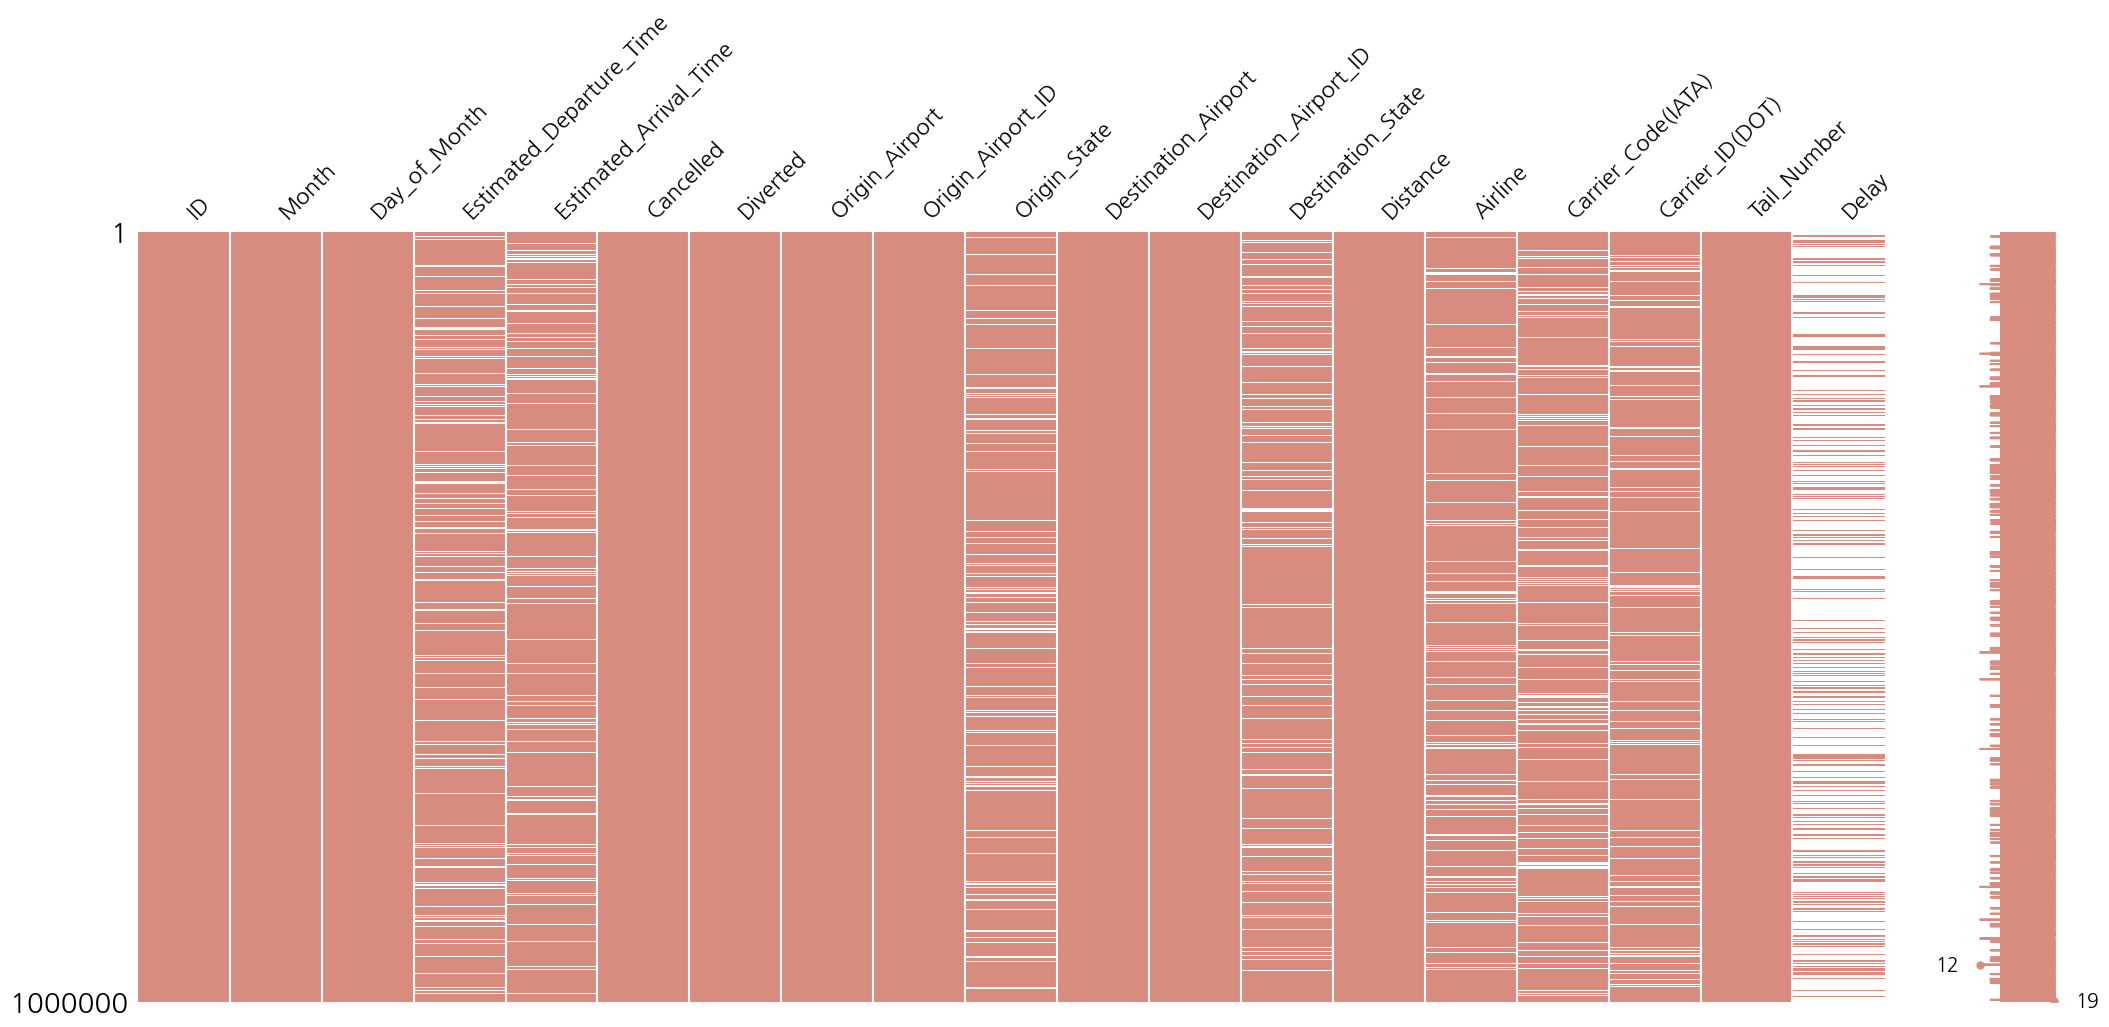

In [ ]:
import missingno as mino
mino.matrix(train, color=(0.85, 0.55, 0.5))

<Axes: >

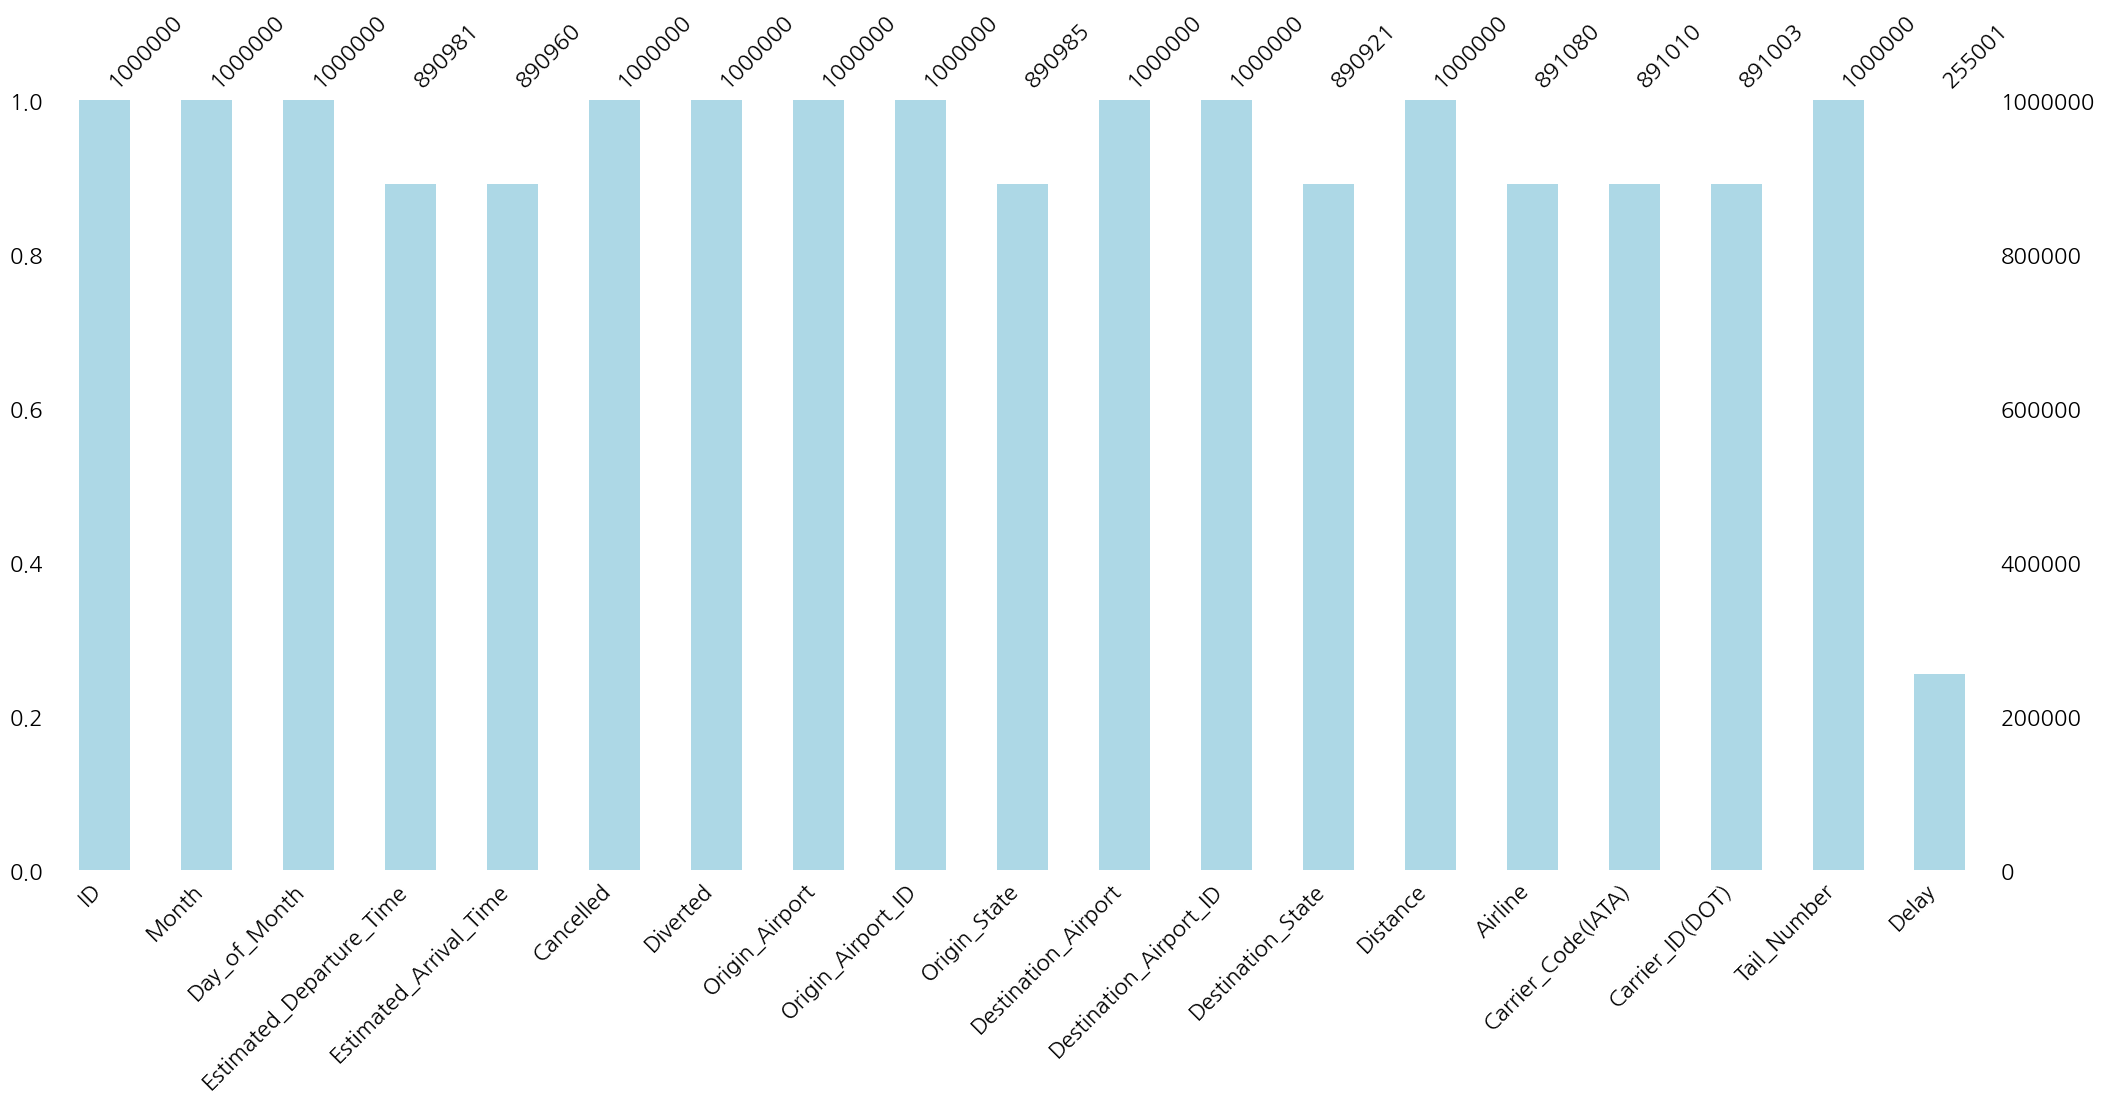

In [ ]:
mino.bar(train, color='lightblue')

In [ ]:
test.isna().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    108984
Estimated_Arrival_Time      109048
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                106505
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           106523
Distance                         0
Airline                     106527
Carrier_Code(IATA)          108993
Carrier_ID(DOT)             109006
Tail_Number                      0
dtype: int64

=> train data와 test data 모두 Estimated_Departure_Time, Estimated_Arrival_Time, Origin_State, Destination_State, Airline, Carrier_Code(IATA), Carrier_ID(DOT), Delay에는 NULL 값이 존재함을 알 수 있다.

* 도착, 출발 시간 모두 없는 열은 삭제

In [ ]:
# 도착, 출발 시간 모두 없는 열은 삭제
train = train.dropna(subset=['Estimated_Arrival_Time', 'Estimated_Departure_Time'], how ='all', axis=0)

* 남은 null값을 최빈값으로 대체

In [ ]:
#  남은 null값을 최빈값으로 대체
# 이때, Carrier_ID(DOT)는 해당 항공사별로 하나가 할당되기 때문에 Airline와 동일한 데이터이다.
# => 따라서, 두개 모두 결측치가 아닌 이상 데이터 복구가 가능하므로 따로 처리한다.
NaN_col = ['Origin_State','Destination_State', 'Estimated_Departure_Time', 'Estimated_Arrival_Time','Carrier_Code(IATA)']

for col in NaN_col:
    mode = train[col].mode()[0]
    train[col] = train[col].fillna(mode)

    if col in test.columns:
        test[col] = test[col].fillna(mode)

print(train.isna().sum())

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time         0
Estimated_Arrival_Time           0
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                     0
Destination_Airport              0
Destination_Airport_ID           0
Destination_State                0
Distance                         0
Airline                     107640
Carrier_Code(IATA)               0
Carrier_ID(DOT)             107727
Tail_Number                      0
Delay                       736342
dtype: int64


*  Carrier_ID(DOT)와 Airline 데이터 복구

In [ ]:
num1 = train['Carrier_ID(DOT)'].isna().sum()
num2 = train['Airline'].isna().sum()
print(f'복구 가능한 데이터의 수: {num1-num2}')

복구 가능한 데이터의 수: 87


In [ ]:
# Carrier_ID를 저장할 dictionary 만들기
airline_to_cid = {}
for _, row in train[(~train['Carrier_ID(DOT)'].isnull() & ~train['Airline'].isnull())].iterrows():
    airline_to_cid[row['Airline']] = row['Carrier_ID(DOT)']

In [ ]:
# 복구하기
def to_cid(x):
    return airline_to_cid[x]

cond1 = train['Carrier_ID(DOT)'].isnull()
cond2 = ~train['Airline'].isnull()
train.loc[cond1&cond2, 'Carrier_ID(DOT)'] = train.loc[cond1&cond2, 'Airline'].apply(lambda x: to_cid(x))

In [ ]:
# 복구하지 못한 데이터 제거 및 Airline 칼럼 삭제
train = train.dropna(subset=['Carrier_ID(DOT)'], how='any', axis=0)
train = train.drop('Airline', axis=1)
test = test.drop('Airline', axis=1)

# 3) 변수 삭제 및 필요 열 추가

In [ ]:
# 그래프 스타일 지정
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-muted')

(1) Month_day : 월별 날짜를 일별(day 366)로 변환



In [ ]:
# (1) Month_day

def to_days(x):
    month_to_days = {1:0, 2:31, 3:60, 4:91, 5:121, 6:152, 7:182, 8:213, 9:244, 10:274, 11:305, 12:335}
    return month_to_days[x]

k= train['Month'].apply(lambda x: to_days(x))
train['Month_day']=k+train['Day_of_Month']

p= test['Month'].apply(lambda x: to_days(x))
test['Month_day']=p+test['Day_of_Month']

<Axes: xlabel='Month_day', ylabel='Density'>

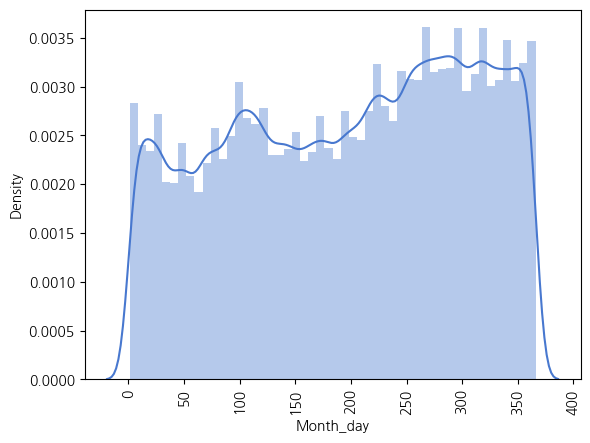

In [ ]:
plt.xticks(rotation=90)
sns.distplot(train['Month_day'])

(2) flying_time : 비행시간( 도착시간-출발시간)

In [ ]:
# (2) flying_time

train['flying_time']=train['Estimated_Arrival_Time']-train['Estimated_Departure_Time']

test['flying_time']=test['Estimated_Arrival_Time']-test['Estimated_Departure_Time']

<Axes: xlabel='flying_time', ylabel='Density'>

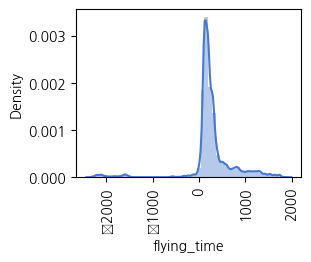

In [ ]:
plt.subplot(2,2,4)
plt.xticks(rotation=90)
sns.distplot(train['flying_time'])

(3) 동일한 의미를 가지는 변수 처리

* Origin_Airport_ID, Origin_Airport 변수는 동일한 의미를 가지므로 Origin_Airport만 남긴다.




In [ ]:
train['Origin_Airport_ID'].value_counts()

13930    49235
10397    43128
11292    39346
12892    31116
11298    30171
         ...  
14582       13
11997       13
11336        9
10245        8
10562        6
Name: Origin_Airport_ID, Length: 374, dtype: int64

In [ ]:
train['Origin_Airport'].value_counts()

ORD    49235
ATL    43128
DEN    39346
LAX    31116
DFW    30171
       ...  
ROP       13
GST       13
DLG        9
AKN        8
BFM        6
Name: Origin_Airport, Length: 374, dtype: int64

In [ ]:
train = train.drop('Origin_Airport_ID', axis=1)
test = test.drop('Origin_Airport_ID', axis=1)

* Destination_Airport, Destination_Airport_ID 변수는 동일한 의미를 가지므로 Destination_Airport만 남긴다.

In [ ]:
train['Destination_Airport'].value_counts()

ORD    49041
ATL    42585
DEN    38718
LAX    31184
DFW    29465
       ...  
BFM       11
DLG        8
GST        6
AKN        3
YNG        1
Name: Destination_Airport, Length: 375, dtype: int64

In [ ]:
train['Destination_Airport_ID'].value_counts()

13930    49041
10397    42585
11292    38718
12892    31184
11298    29465
         ...  
10562       11
11336        8
11997        6
10245        3
16133        1
Name: Destination_Airport_ID, Length: 375, dtype: int64

In [ ]:
train = train.drop('Destination_Airport_ID', axis=1)
test = test.drop('Destination_Airport_ID', axis=1)

In [ ]:
train.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Month_day,flying_time
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,Illinois,SLC,Utah,1250.0,UA,20304.0,N125SY,None,228,284.0
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,North Carolina,LGA,New York,544.0,AA,19805.0,N103US,None,250,195.0
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,California,EWR,New Jersey,2454.0,UA,19977.0,N595UA,None,192,830.0
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,California,ACV,California,250.0,UA,20304.0,N161SY,None,11,119.0
5,TRAIN_000005,4,13,1545.0,1900.0,0,0,EWR,California,DCA,Virginia,199.0,UA,20452.0,N657RW,Not_Delayed,104,355.0


(4) 라벨 인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder

qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Carrier_Code(IATA)',
            'Carrier_ID(DOT)', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train[i])
    train[i] = le.transform(train[i])

    for label in np.unique(test[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[i] = le.transform(test[i])

In [ ]:
train

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,Month_day,flying_time
1,TRAIN_000001,8,15,740.0,1024.0,0,0,256,11,331,45,1250.0,8,12,310,None,228,284.0
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,74,31,204,30,544.0,0,4,140,None,250,195.0
3,TRAIN_000003,7,10,905.0,1735.0,0,0,195,4,119,28,2454.0,8,6,3018,None,192,830.0
4,TRAIN_000004,1,11,900.0,1019.0,0,0,322,4,7,4,250.0,8,12,554,None,11,119.0
5,TRAIN_000005,4,13,1545.0,1900.0,0,0,119,4,93,47,199.0,8,24,3432,Not_Delayed,104,355.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TRAIN_999995,9,18,936.0,1243.0,0,0,256,4,270,4,678.0,8,6,2475,None,262,307.0
999996,TRAIN_999996,5,30,920.0,1028.0,0,0,122,4,242,21,223.0,3,12,2292,None,151,108.0
999997,TRAIN_999997,6,28,800.0,1340.0,0,0,248,4,159,42,1642.0,10,0,992,None,180,540.0
999998,TRAIN_999998,9,27,1613.0,1824.0,0,0,45,41,22,4,214.0,3,3,6203,None,271,211.0


In [ ]:
test

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Month_day,flying_time
0,TEST_000000,12,16,1156.0,1900.0,0,0,169,42,310,42,191.0,8,28,4384,351,744.0
1,TEST_000001,9,12,1500.0,1715.0,0,0,119,28,22,4,746.0,3,3,1934,256,215.0
2,TEST_000002,3,6,1600.0,1915.0,0,0,256,11,204,30,733.0,8,6,2145,66,315.0
3,TEST_000003,5,18,1920.0,2045.0,0,0,248,4,195,4,337.0,10,0,5482,139,125.0
4,TEST_000004,7,7,1915.0,2152.0,0,0,127,7,195,4,2343.0,2,19,5961,189,237.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TEST_999995,6,2,600.0,2240.0,0,0,195,4,94,5,862.0,10,0,3828,154,1640.0
999996,TEST_999996,6,8,600.0,648.0,0,0,57,30,256,11,473.0,8,6,2067,160,48.0
999997,TEST_999997,6,11,1710.0,1907.0,0,0,167,4,103,20,383.0,8,16,2616,163,197.0
999998,TEST_999998,11,17,600.0,500.0,0,0,309,4,47,19,2588.0,2,19,6339,322,-100.0


ID, Month, Day_of_Month, Estimated_Departure_Time, 	Estimated_Arrival_Time	는 우선 남기긴 했는데 삭제해도 됨